In [92]:
import astropy.units as u
import pytest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ctapipe.image import tailcuts_clean, toymodel
from ctapipe.image.muon import MuonRingFitter
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
#from ctapipe.visualization.bokeh import ArrayDisplay

from scipy.ndimage import correlate1d

from scipy.stats import multivariate_normal, norm, skewnorm, uniform

In [2]:
import astropy.units as u
import pytest

from ctapipe.image import tailcuts_clean, toymodel
from ctapipe.image.muon import MuonRingFitter

In [3]:
from ctapipe.instrument import SubarrayDescription

In [4]:
#subarr=SubarrayDescription.read(
#        "dataset://corsika_theta_20.0_az_180.0_run10.simtel.gz",
#        focal_length_choice="EQUIVALENT")

In [5]:
#subarr=SubarrayDescription.read(
#        "dataset://gamma_test_large.simtel.gz",
#        focal_length_choice="EQUIVALENT")

In [6]:
subarr=SubarrayDescription.read(
        "dataset://gamma_prod5.simtel.zst",
        focal_length_choice="EQUIVALENT")

In [7]:
#ArrayDisplay(subarr).values

In [8]:
#for i in np.arange(len(subarr.tel)):
#    print(i," ",subarr.tel[int(i+1)].camera.geometry.name)

In [9]:
#SST-1M DigiCam (corsika_theta_20.0_az_180.0_run10.simtel.gz)
#geom = subarr.tel[4].camera.geometry
#optics = subarr.tel[4].optics

#Mace (corsika_theta_20.0_az_180.0_run10.simtel.gz)
#geom = subarr.tel[1].camera.geometry
#optics = subarr.tel[1].optics


#LST LSTCam
geom = subarr.tel[1].camera.geometry
optics = subarr.tel[1].optics
#MST FlashCam
#geom = subarr.tel[5].camera.geometry
#optics = subarr.tel[5].optics
#MST NectarCam
#geom = subarr.tel[100].camera.geometry
#optics = subarr.tel[100].optics
#SST CHEC
#geom = subarr.tel[60].camera.geometry
#optics = subarr.tel[60].optics

#geom = subarr.tel[50].camera.geometry

#geom = subarr.tel[8].camera.geometry
#def prod5_mst_flashcam(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[5]
#def prod5_mst_nectarcam(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[100]
#def prod5_lst(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[1]
#def prod5_sst(subarray_prod5_paranal):
#    return subarray_prod5_paranal.tel[60]

In [10]:
geom

CameraGeometry(name='LSTCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=40.893 deg, frame=<CameraFrame Frame (focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>)

In [11]:
tel_fov = np.arctan((np.max( np.sqrt(geom.pix_x ** 2 + geom.pix_y ** 2 ) ) * 2.0) / optics.effective_focal_length)

In [12]:
optics

OpticsDescription(name=LST, size_type=LST, reflector_shape=PARABOLIC, equivalent_focal_length=28.00 m, effective_focal_length=29.31 m, n_mirrors=1, mirror_area=386.73 m2)

In [13]:
#optics.mirror_area.to_value()
lst_mirror_area = 386.7332458496094
lst_muon_npe = 2500
expected_npe = lst_muon_npe * optics.mirror_area.to_value() / lst_mirror_area
print(expected_npe)

2500.0


In [14]:
optics.effective_focal_length

<Quantity 29.30565071 m>

In [15]:
geom.name

'LSTCam'

In [16]:
geom.frame

<CameraFrame Frame (focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>

In [17]:
geom.pix_rotation= 90 * u.deg

In [18]:
# flashCam example
#center_xs = optics.effective_focal_length * np.tan(( -2.5 * u.deg).to_value(u.rad))
#center_ys = optics.effective_focal_length * np.tan((  1.3 * u.deg).to_value(u.rad))
#radius = optics.effective_focal_length * np.tan(( 1.1 * u.deg).to_value(u.rad))
center_xs = geom.frame.focal_length * np.tan(( -0.3 * u.deg).to_value(u.rad))
center_ys = geom.frame.focal_length * np.tan((  0.4 * u.deg).to_value(u.rad))
radius = geom.frame.focal_length * np.tan(( 1.1 * u.deg).to_value(u.rad))

width = 0.1 * radius 

muon_model = toymodel.RingGaussian(
    x=center_xs,
    y=center_ys,
    radius=radius,
    sigma=width,
    rho=0.5,
    phi0=-40.0 * u.deg)

In [157]:
circumference = 2 * np.pi * radius
oversampling = 3
pixels_on_circle = circumference / geom.pixel_width[0] * oversampling

print(center_xs)
print(center_ys)
print(radius)
print(circumference)
print(pixels_on_circle)

print(oversampling)

-0.14660899695960355 m
0.1954800520539014 m
0.537627465416258 m
3.3780129914396335 m
206.8171270081961
3


In [158]:
charge, _, _ = muon_model.generate_image(
        geom,
        intensity=3000,
        nsb_level_pe=0,
    )
survivors = tailcuts_clean(geom, charge, 2, 1)

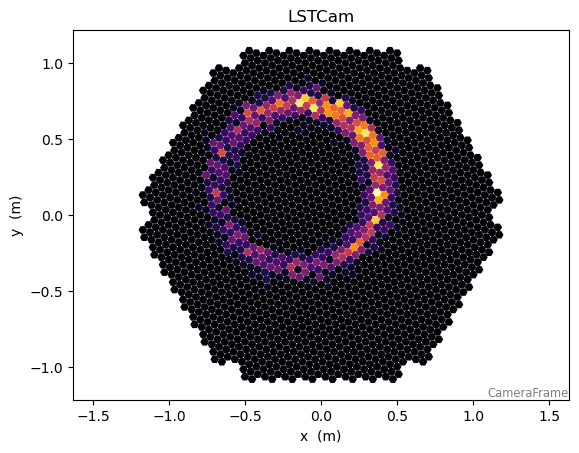

In [159]:
disp = CameraDisplay(geom,charge)

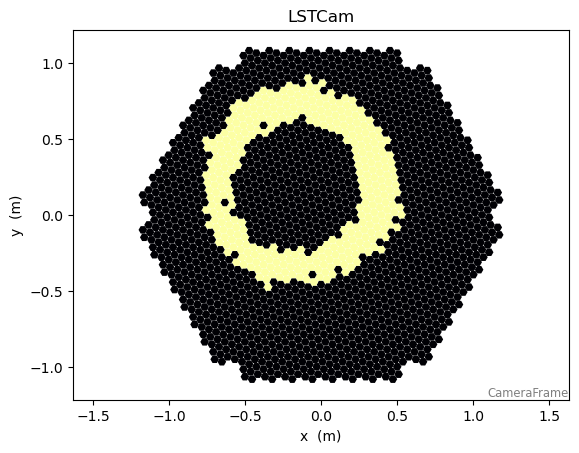

In [160]:
disp_s = CameraDisplay(geom,survivors)

In [161]:
rr=np.sqrt((geom.pix_y[survivors]-center_ys)*(geom.pix_y[survivors]-center_ys) + (geom.pix_x[survivors]-center_xs)*(geom.pix_x[survivors]-center_xs))

In [162]:
angle = np.arctan2(geom.pix_y[survivors]-center_ys,geom.pix_x[survivors]-center_xs).to(u.deg).to_value()

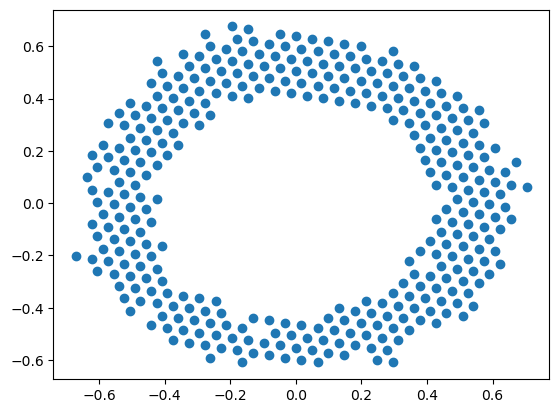

In [163]:
plt.plot((geom.pix_y[survivors]-center_ys),(geom.pix_x[survivors]-center_xs),'o')

In [164]:
len(charge[survivors])

354

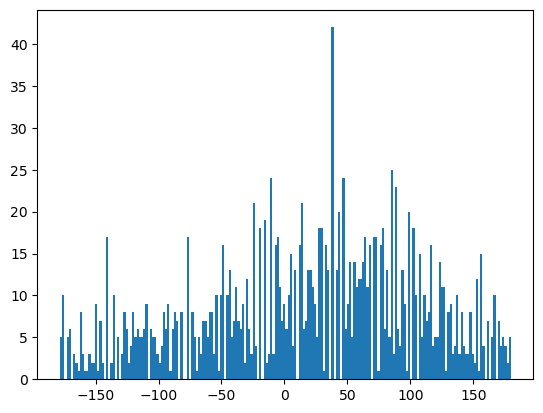

In [165]:
hist=plt.hist(angle,bins=int(pixels_on_circle),weights=charge[survivors])

In [166]:
hist_bin_center = [(hist[1][i+1] + hist[1][i])/2.0 for i in np.arange(len(hist[0]))]

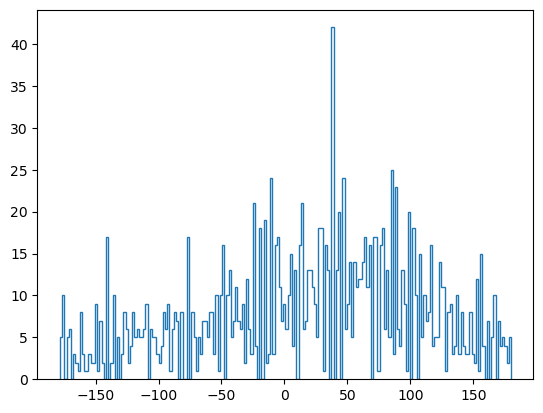

In [167]:
plt.stairs(hist[0],hist[1])

In [168]:
len(hist[0])

206

In [173]:
length = correlate1d(hist[0], np.ones(int(3)), mode="wrap", axis=0)/3

Text(0.5, 0, 'phi, deg')

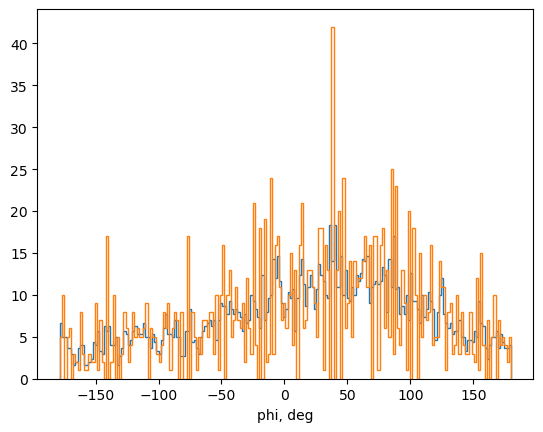

In [175]:
plt.stairs(length,hist[1])
plt.stairs(hist[0],hist[1])
plt.xlabel('phi, deg')

(array([ 3.,  2.,  8., 21., 46., 65., 36., 19.,  4.,  2.]),
 array([-20.66666667, -16.8       , -12.93333333,  -9.06666667,
         -5.2       ,  -1.33333333,   2.53333333,   6.4       ,
         10.26666667,  14.13333333,  18.        ]),
 <BarContainer object of 10 artists>)

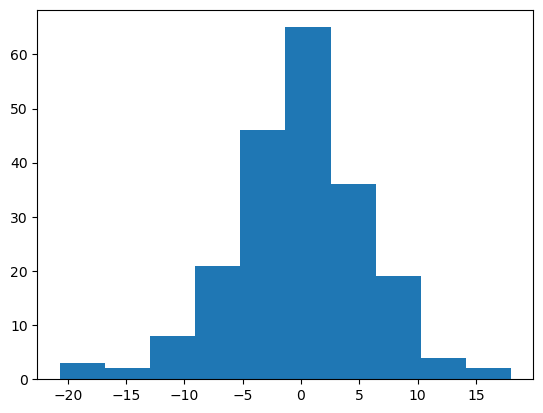

In [98]:
plt.hist(length/3.0 - hist[0])

(array([125.,  83.,  63.,  17.,  28.,  19.,   4.,   4.,   1.,   2.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

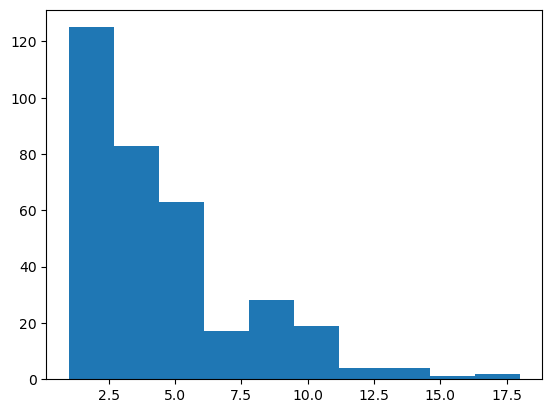

In [64]:
plt.hist(charge[survivors])

In [77]:
print(center_xs)
print(center_ys)
print(radius)

-0.14660899695960355 m
0.1954800520539014 m
0.537627465416258 m


In [78]:
geom.pixel_width

<Quantity [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049] m>

In [21]:
np.sum(disp.image.data)

np.float64(1514.0)

In [22]:
type(disp)

ctapipe.visualization.mpl_camera.CameraDisplay

(array([1.5e+03, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 8.0e+01, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 5.4e+01, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 5.6e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 2.7e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 3.6e+01,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.7e+01, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 1.7e+01, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 1.6e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 1.2e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+01,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 9.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 4.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        3.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
      

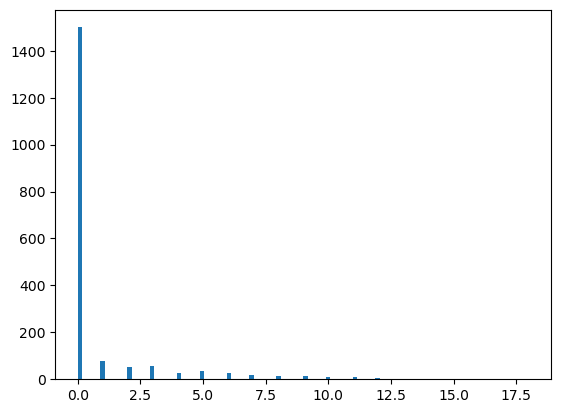

In [23]:
plt.hist(charge,bins=100)

In [34]:
df=pd.DataFrame(data=np.column_stack([charge,geom.pix_x.to_value(),geom.pix_y.to_value()]),columns=["charge","pix_x","pix_y"])

<Axes: >

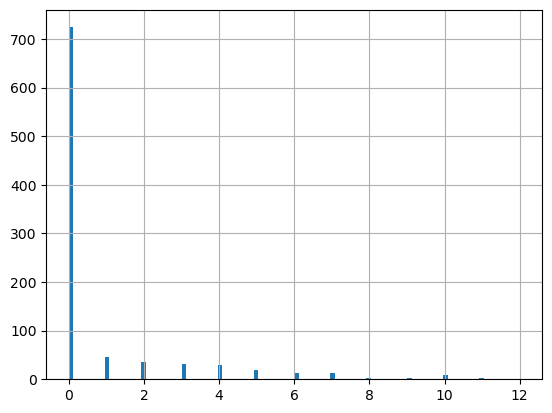

In [35]:
df[df["pix_x"]<0.0]["charge"].hist(bins=100)

In [36]:
np.sum(df[df["pix_x"]<0.0]["charge"].values)

np.float64(766.0)

In [37]:
df_cut=df[df["pix_x"]>0.0]

In [38]:
df_cut=df_cut[df_cut["pix_y"]>-0.25]

In [39]:
np.sum(df_cut["charge"].values)

np.float64(788.0)

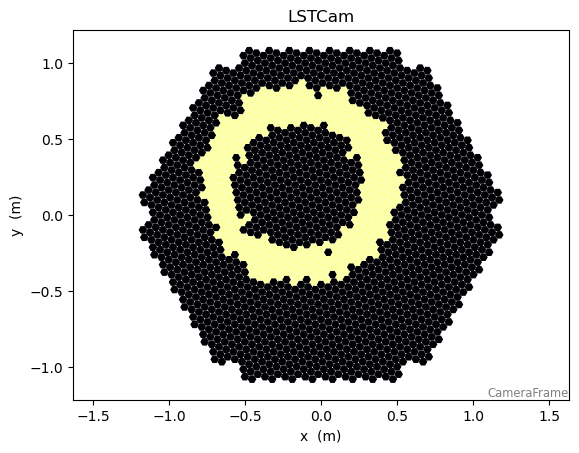

In [40]:
disp = CameraDisplay(geom,survivors)

In [41]:
arr = np.array([2, -3, 0, 4, -1, 7])

# Apply the transformation
result = np.where(arr < 0, arr * -1.0, arr).sum()

print("Original array:", arr)
print("Transformed array:", result)

Original array: [ 2 -3  0  4 -1  7]
Transformed array: 17.0


In [42]:
u.isclose((0.0 * u.m),(0.1 * u.m))

np.False_

In [43]:
disp = CameraDisplay(geom,image)

NameError: name 'image' is not defined

In [32]:
dist=uniform(-0.2, 0.2)        
dist.pdf(0.0)

np.float64(5.0)

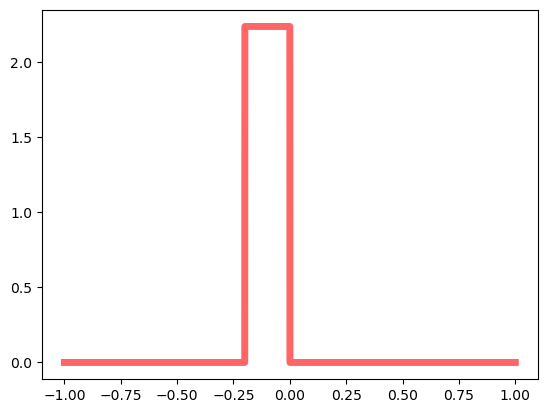

In [37]:
x = np.linspace(-1.0, 1.0, 10000)
plt.plot(x, (np.sqrt(dist.pdf(x))),'r-', lw=5, alpha=0.6, label='norm pdf')

In [38]:
np.zeros(x.shape)

array([0., 0., 0., ..., 0., 0., 0.])

In [6]:
mc_h5_table

/simulation/event/subarray/shower (Table(np.int64(9984),)fletcher32, shuffle, blosc:zstd(5)) np.str_('Storage of EventIndexContainer,SimulatedShowerContainer')
  description := {
  "obs_id": Int32Col(shape=(), dflt=np.int32(0), pos=0),
  "event_id": Int64Col(shape=(), dflt=np.int64(0), pos=1),
  "true_energy": Float64Col(shape=(), dflt=np.float64(0.0), pos=2),
  "true_alt": Float64Col(shape=(), dflt=np.float64(0.0), pos=3),
  "true_az": Float64Col(shape=(), dflt=np.float64(0.0), pos=4),
  "true_core_x": Float64Col(shape=(), dflt=np.float64(0.0), pos=5),
  "true_core_y": Float64Col(shape=(), dflt=np.float64(0.0), pos=6),
  "true_h_first_int": Float64Col(shape=(), dflt=np.float64(0.0), pos=7),
  "true_x_max": Float64Col(shape=(), dflt=np.float64(0.0), pos=8),
  "true_starting_grammage": Float64Col(shape=(), dflt=np.float64(0.0), pos=9),
  "true_shower_primary_id": Int64Col(shape=(), dflt=np.int64(0), pos=10)}
  byteorder := 'little'
  chunkshape := (np.int64(780),)

In [7]:
muon_h5_table=h5file.root.dl1.event.telescope.muon.tel_001

In [8]:
muon_h5_table

/dl1/event/telescope/muon/tel_001 (Table(np.int64(9984),)fletcher32, shuffle, blosc:zstd(5)) np.str_('Storage of TelEventIndexContainer,MuonRingContainer,MuonParametersContainer,MuonEfficiencyContainer')
  description := {
  "obs_id": Int32Col(shape=(), dflt=np.int32(0), pos=0),
  "event_id": Int64Col(shape=(), dflt=np.int64(0), pos=1),
  "tel_id": Int16Col(shape=(), dflt=np.int16(0), pos=2),
  "muonring_center_fov_lon": Float64Col(shape=(), dflt=np.float64(0.0), pos=3),
  "muonring_center_fov_lat": Float64Col(shape=(), dflt=np.float64(0.0), pos=4),
  "muonring_radius": Float64Col(shape=(), dflt=np.float64(0.0), pos=5),
  "muonring_center_phi": Float64Col(shape=(), dflt=np.float64(0.0), pos=6),
  "muonring_center_distance": Float64Col(shape=(), dflt=np.float64(0.0), pos=7),
  "muonparameters_containment": Float64Col(shape=(), dflt=np.float64(0.0), pos=8),
  "muonparameters_completeness": Float64Col(shape=(), dflt=np.float64(0.0), pos=9),
  "muonparameters_intensity_ratio": Float32Col(s

In [9]:
muon_h5_table[0]

np.void((100, 100, 1, -0.08148999292648822, 0.009378727500590682, 1.1777137991475297, 173.4346836564115, 0.08202791888551991, 1.0, 0.9, 0.9639328, 0.0011544723147290047, 2472.7192, 0.0, 101, -0.137458, nan, nan, nan, 0.027365635656256614, 5.733629867010934, 5.602308284487245, -1.2201038224042233, 0.18833863195456943, True, False, 1968.8696677350385), dtype=[('obs_id', '<i4'), ('event_id', '<i8'), ('tel_id', '<i2'), ('muonring_center_fov_lon', '<f8'), ('muonring_center_fov_lat', '<f8'), ('muonring_radius', '<f8'), ('muonring_center_phi', '<f8'), ('muonring_center_distance', '<f8'), ('muonparameters_containment', '<f8'), ('muonparameters_completeness', '<f8'), ('muonparameters_intensity_ratio', '<f4'), ('muonparameters_mean_squared_error', '<f8'), ('muonparameters_ring_intensity', '<f4'), ('muonparameters_intensity_outside_ring', '<f4'), ('muonparameters_n_pixels_in_ring', '<i8'), ('muonparameters_mean_intensity_outside_ring', '<f4'), ('muonparameters_radial_std_dev', '<f8'), ('muonparam

In [10]:
tel_id=1
#h5filename="./data/run_000/dl1_muon_ctapipe_run000.h5"
h5filename="./data/dl1_muon_ctapipe.h5"
subarray = SubarrayDescription.from_hdf(h5filename)
geom = subarray.tel[tel_id].camera.geometry

In [11]:
geom

CameraGeometry(name='LSTCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=40.893 deg, frame=<CameraFrame Frame (focal_length=29.30565071105957 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>)

In [12]:
focal_length = subarray.tel[tel_id].optics.effective_focal_length

In [14]:
focal_length.to_value()

np.float64(29.30565071105957)

In [14]:
trigger_table = read_table(h5filename, "/dl1/event/subarray/trigger")
simshower_table = read_table(h5filename, "/simulation/event/subarray/shower")
mu_reco_table = read_table(h5filename, "/dl1/event/telescope/muon/tel_001")
#image_table = read_table(h5filename, "/dl1/event/telescope/images/tel_001")
#true_image_table = read_table(h5filename, "/simulation/event/telescope/images/tel_001")
#

In [15]:
mu_table = join(left=trigger_table,
                right=mu_reco_table,
                keys=["obs_id", "event_id"])

In [16]:
mu_table = join(left=mu_table,
                right=simshower_table,
                keys=["obs_id", "event_id"])

In [17]:
mu_table.sort(["obs_id", "event_id"])

In [18]:
mu_table

obs_id,event_id,time,tels_with_trigger,event_type,tel_id,muonring_center_fov_lon,muonring_center_fov_lat,muonring_radius,muonring_center_phi,muonring_center_distance,muonparameters_containment,muonparameters_completeness,muonparameters_intensity_ratio,muonparameters_mean_squared_error,muonparameters_ring_intensity,muonparameters_intensity_outside_ring,muonparameters_n_pixels_in_ring,muonparameters_mean_intensity_outside_ring,muonparameters_radial_std_dev,muonparameters_skewness,muonparameters_excess_kurtosis,muonefficiency_width,muonefficiency_impact,muonefficiency_impact_x,muonefficiency_impact_y,muonefficiency_optical_efficiency,muonefficiency_is_valid,muonefficiency_parameters_at_limit,muonefficiency_likelihood_value,true_energy,true_alt,true_az,true_core_x,true_core_y,true_h_first_int,true_x_max,true_starting_grammage,true_shower_primary_id
,,,,,,deg,deg,deg,deg,deg,,,,deg2,,,,,deg,,,deg,m,m,m,,,,,TeV,deg,deg,m,m,m,g / cm2,g / cm2,
int32,int64,Time,bool[1],int64,int16,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,float32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
100,100,1743155700.781457,True,32,1,-0.08148999292648822,0.009378727500590682,1.1777137991475297,173.4346836564115,0.08202791888551991,1.0,0.9,0.9639328,0.0011544723147290047,2472.7192,0.0,101,-0.137458,nan,nan,nan,0.027365635656256614,5.733629867010934,5.602308284487245,-1.2201038224042233,0.18833863195456943,True,False,1968.8696677350385,0.0437641516327858,79.9963708422941,179.97079912006535,5.2658514976501465,5.8399248123168945,1.0,610.0,580.0,2
100,200,1743155700.890501,True,32,1,0.02624499281909195,-0.0050619643885416185,1.1887244727470923,-10.916787628667795,0.026728694909124377,1.0,0.9333333333333333,0.9335027,0.0015326462805099084,2597.2126,0.0,119,0.041377954,0.13320679012105943,6.4472984492581,36.51990854288939,0.03287950699987974,1.0980895769353827e-05,1.0980891172671814e-05,1.0047454952666621e-08,0.19892594037756756,True,True,2164.3517028048086,0.18820133805274963,80.00290050314062,180.01468991567185,5.852324962615967,-5.821779251098633,1.0,610.0,580.0,2
100,300,1743155700.998187,True,32,1,-0.11480748752381907,0.09887398695847582,1.156837539263355,139.26445931469473,0.15151509656993498,1.0,0.9333333333333333,0.90192354,0.002125629217275687,2430.8015,0.0,107,-0.052768555,0.12922454594046737,3.699661733527503,-5.2136969365942925,0.04422407251745933,6.752111229972731,6.29707855604448,2.4367617283863914,0.19944700603587345,True,False,2013.9141359362868,0.023676853626966476,80.0000591444459,179.9704439502285,0.021167412400245667,5.211458206176758,1.0,610.0,580.0,2
100,400,1743155701.103146,True,32,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False,nan,0.017206022515892982,79.99248446465636,179.99516923502395,-7.965814113616943,-5.719479560852051,1.0,610.0,580.0,2
100,500,1743155701.211495,True,32,1,-0.10026397118576263,-0.14512910501239001,1.1469430363090263,-124.63906435568262,0.17639535435956574,1.0,0.8333333333333334,0.8692238,0.0022541297615344172,2475.6663,0.0,109,-0.029685503,0.14627955997166195,5.806855115031032,42.41502993444576,0.04590782328659885,7.295575325419396,7.06564991534033,-1.817143528376201,0.20630479744093097,True,False,1895.0948972717779,0.020825998857617378,79.99318797414087,180.01940274619918,-0.07761910557746887,6.992401599884033,1.0,610.0,580.0,2
100,600,1743155701.323431,True,32,1,-0.090677224866488,-0.029434790596927652,1.147923472984945,-162.01601894576163,0.09533501983517186,1.0,0.9666666666666667,0.9484459,0.0011360887879676117,2534.2832,0.0,113,-0.037713505,0.03366773803408529,-818.0590105025993,-6213.373529851082,0.029319528921196034,3.4620414746829806,1.6324728501488073,-3.0529925591052685,0.18802848483947676,True,False,1922.0127963086388,0.04290660470724106,79.99855650282849,180.04788463503812,4.811529159545898,0.17253585159

In [19]:
keys_list=['obs_id',
 'event_id',
 'muonring_center_fov_lon',
 'muonring_center_fov_lat',
 'muonring_radius',
 'muonring_center_phi',
 'muonring_center_distance',
 'muonparameters_containment',
 'muonparameters_completeness',
 'muonparameters_intensity_ratio',
 'muonparameters_mean_squared_error',
 'muonparameters_ring_intensity',
 'muonparameters_intensity_outside_ring',
 'muonparameters_n_pixels_in_ring',
 'muonparameters_mean_intensity_outside_ring',
 'muonparameters_radial_std_dev',
 'muonparameters_skewness',
 'muonparameters_excess_kurtosis',
 'muonefficiency_width',
 'muonefficiency_impact',
 'muonefficiency_impact_x',
 'muonefficiency_impact_y',
 'muonefficiency_optical_efficiency',
 'muonefficiency_is_valid',
 'muonefficiency_parameters_at_limit',
 'muonefficiency_likelihood_value',
 'true_energy',
 'true_alt',
 'true_az',
 'true_core_x',
 'true_core_y',
 'true_h_first_int',
 'true_x_max',
 'true_starting_grammage',
 'true_shower_primary_id']

In [20]:
mu_table_tr=mu_table[keys_list]

In [21]:
df_mu=mu_table_tr.to_pandas()

In [28]:
#df_mu.fillna

,obs_id,event_id,muonring_center_fov_lon,muonring_center_fov_lat,muonring_radius,muonring_center_phi,muonring_center_distance,muonparameters_containment,muonparameters_completeness,muonparameters_intensity_ratio,...,muonefficiency_likelihood_value,true_energy,true_alt,true_az,true_core_x,true_core_y,true_h_first_int,true_x_max,true_starting_grammage,true_shower_primary_id
0,100,100,-0.081490,0.009379,1.177714,173.434684,0.082028,1.0,0.900000,0.963933,...,1968.869668,0.043764,79.996371,179.970799,5.265851,5.839925,1.000000,610.0,580.0,2
1,100,200,0.026245,-0.005062,1.188724,-10.916788,0.026729,1.0,0.933333,0.933503,...,2164.351703,0.188201,80.002901,180.014690,5.852325,-5.821779,1.000000,610.0,580.0,2
2,100,300,-0.114807,0.098874,1.156838,139.264459,0.151515,1.0,0.933333,0.901924,...,2013.914136,0.023677,80.000059,179.970444,0.021167,5.211458,1.000000,610.0,580.0,2
3,100,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.017206,79.992484,179.995169,-7.965814,-5.719480,1.000000,610.0,580.0,2
4,100,500,-0.100264,-0.145129,1.146943,-124.639064,0.176395,1.0,0.833333,0.869224,...,1895.094897,0.020826,79.993188,180.019403,-0.077619,6.992402,1.000000,610.0,580.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99857,109,999600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.035739,79.999048,179.972957,-9.729925,-0.599253,1.000000,610.0,580.0,2
99858,109,999700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.033697,79.999950,179.989159,-6.449430,-0.041273,225.123260,610.0,580.0,2
99859,109,999800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.028862,80.002197,179.987683,-0.226316,-9.226398,908.499207,610.0,580.0,2
99860,109,999900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.044481,80.003686,180.042065,-1.984842,-9.488984,1.000000,610.0,580.0,2


In [22]:
arr_val=np.int32(df_mu['muonring_radius'].isna())

In [23]:
arr_val

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [24]:
arr_val_it=np.arange(len(arr_val))

In [25]:
arr_val_it

array([    0,     1,     2, ..., 99859, 99860, 99861])

In [26]:
the_arr=arr_val*arr_val_it

In [27]:
the_arr=the_arr[the_arr>0]

(array([4069., 4163., 4070., 4137., 4064., 4160., 4076., 4091., 3947.,
        4130.]),
 array([3.00000e+00, 9.98880e+03, 1.99746e+04, 2.99604e+04, 3.99462e+04,
        4.99320e+04, 5.99178e+04, 6.99036e+04, 7.98894e+04, 8.98752e+04,
        9.98610e+04]),
 <BarContainer object of 10 artists>)

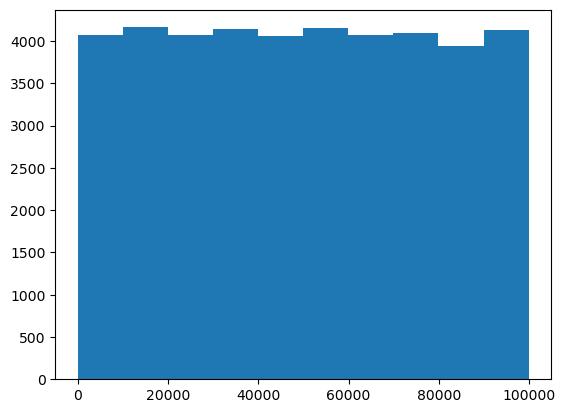

In [19]:
plt.hist(the_arr,bins=10)

In [20]:
df_mu_clean=df_mu.dropna()

In [21]:
df_mu_clean=df_mu_clean.copy()

In [22]:
len(df_mu_clean)/len(df_mu)

0.34908173279125193

(array([  57., 1190., 3409., 6286., 8176., 7445., 5115., 2554.,  592.,
          36.]),
 array([-16.71714273, -13.45485809, -10.19257345,  -6.93028881,
         -3.66800417,  -0.40571953,   2.85656511,   6.11884974,
          9.38113438,  12.64341902,  15.90570366]),
 <BarContainer object of 10 artists>)

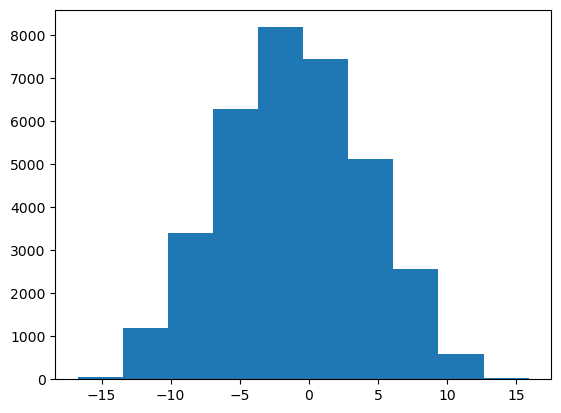

In [23]:
plt.hist(df_mu_clean['muonefficiency_impact_x']-df_mu_clean['true_core_x'])

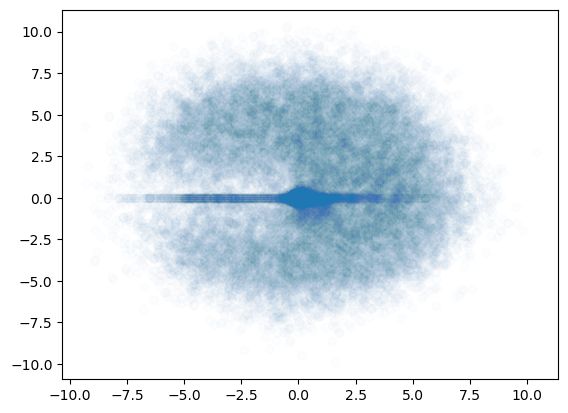

In [24]:
plt.scatter(df_mu_clean['muonefficiency_impact_x'],df_mu_clean['muonefficiency_impact_y'],alpha=0.01)

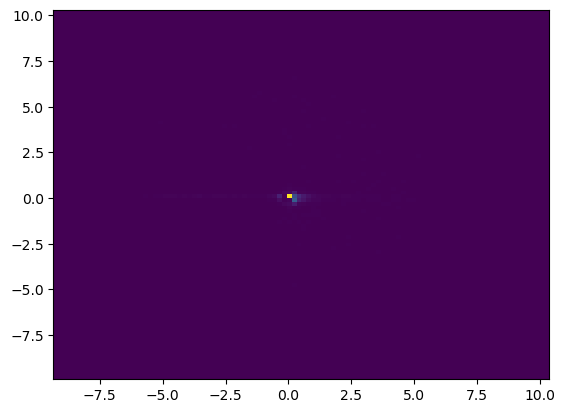

In [25]:
plt.hist2d(df_mu_clean['muonefficiency_impact_x'],df_mu_clean['muonefficiency_impact_y'],bins=100);

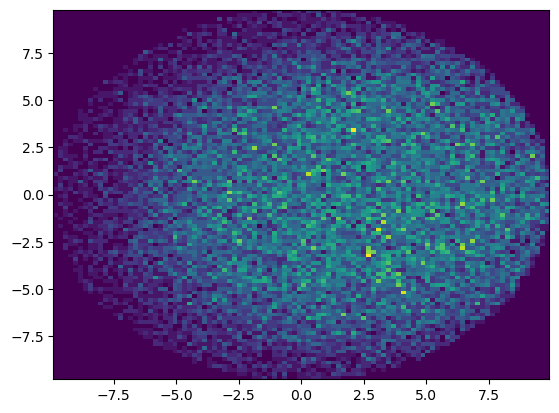

In [38]:
plt.hist2d(df_mu_clean['true_core_x'],df_mu_clean['true_core_y'],bins=100);

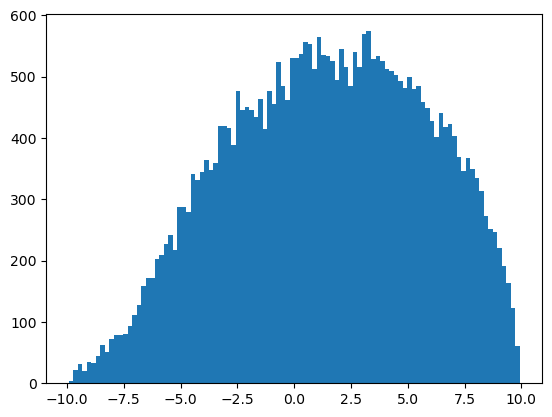

In [39]:
plt.hist(df_mu_clean['true_core_x'],bins=100);

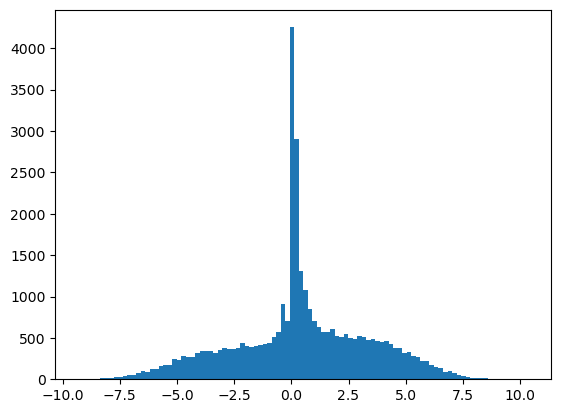

In [26]:
plt.hist(df_mu_clean['muonefficiency_impact_x'],bins=100);

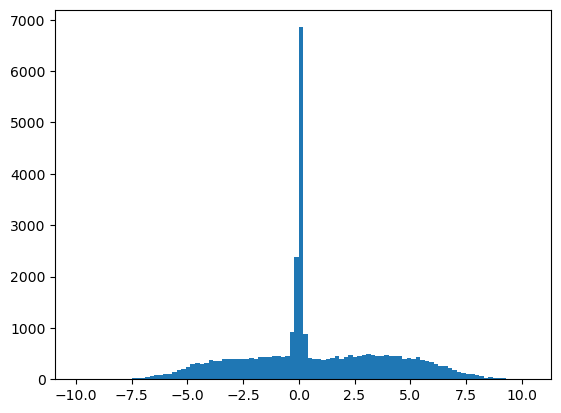

In [27]:
plt.hist(df_mu_clean['muonefficiency_impact_y'],bins=100);

In [28]:
len(df_mu_clean)

34860

In [29]:
df_mu_clean['muonefficiency_impact_r'] = np.sqrt(df_mu_clean['muonefficiency_impact_x'].values*df_mu_clean['muonefficiency_impact_x'].values + df_mu_clean['muonefficiency_impact_y'].values*df_mu_clean['muonefficiency_impact_y'].values)

In [31]:
df_mu_clean['true_core_r'] = np.sqrt(df_mu_clean['true_core_x']*df_mu_clean['true_core_x'] + df_mu_clean['true_core_y']*df_mu_clean['true_core_y'] )

(array([  10.,  108.,  668., 3412., 7448., 8571., 7818., 3885., 2022.,
         918.]),
 array([-8.32921142, -6.50234295, -4.67547448, -2.84860601, -1.02173754,
         0.80513093,  2.6319994 ,  4.45886788,  6.28573635,  8.11260482,
         9.93947329]),
 <BarContainer object of 10 artists>)

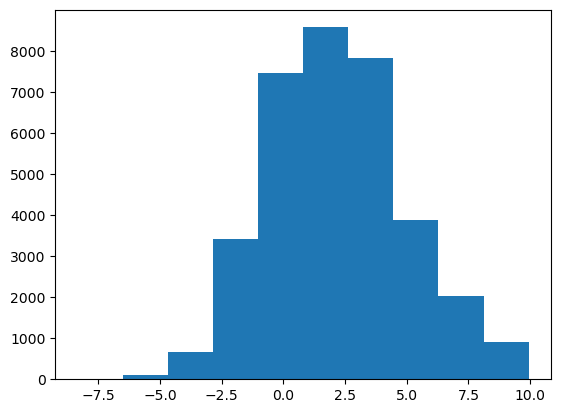

In [33]:
plt.hist(df_mu_clean['true_core_r']-df_mu_clean['muonefficiency_impact_r'])

In [35]:
np.std(df_mu_clean['true_core_r']-df_mu_clean['muonefficiency_impact_r'])

2.780637711061066

In [37]:
np.std(df_mu_clean['true_core_y']-df_mu_clean['muonefficiency_impact_y'])

5.2864587935472365

In [11]:
h5_event_id=the_h5_table[:]['event_id']
h5_mc_core_e=the_h5_table[:]['mc_energy']
h5_mc_core_x=the_h5_table[:]['mc_core_x']
h5_mc_core_y=the_h5_table[:]['mc_core_y']

In [12]:
df_h5 = pd.DataFrame(np.array([h5_event_id,h5_mc_core_e,h5_mc_core_x,h5_mc_core_y]).transpose(), columns=['h5_event_id', 'mc_energy','h5_mc_core_x', 'h5_mc_core_y'])

In [13]:
df_h5['impact_r_array'] = np.sqrt(df_h5['h5_mc_core_x']*df_h5['h5_mc_core_x']+df_h5['h5_mc_core_y']*df_h5['h5_mc_core_y'])

In [14]:
df_h5_filter=df_h5[df_h5['h5_event_id'].isin(df_mu_good['event_id'].values)]

In [15]:
df_h5_filter['']

,h5_event_id,mc_energy,h5_mc_core_x,h5_mc_core_y,impact_r_array
14,1500.0,0.017107,8.540619,-2.243623,8.830403
33,3400.0,0.021559,-3.928153,8.423265,9.294179
42,4300.0,0.015795,-5.776220,-7.130515,9.176544
66,6700.0,0.019599,-6.319252,-5.713272,8.519063
117,11800.0,0.020526,2.780109,-2.604249,3.809346
...,...,...,...,...,...
9560,957700.0,0.031177,-7.156468,0.472839,7.172071
9704,972100.0,0.019962,-4.720030,-5.122269,6.965366
9738,975500.0,0.016474,4.319536,1.756801,4.663126
9931,994800.0,0.025321,-1.570009,7.501085,7.663629


In [16]:
len(df_h5)/10000.0

0.9984

(array([ 4.,  2., 23., 25., 48., 36., 23., 10.,  7.,  1.]),
 array([-5.14334938, -4.05878804, -2.97422669, -1.88966535, -0.805104  ,
         0.27945734,  1.36401869,  2.44858004,  3.53314138,  4.61770273,
         5.70226407]),
 <BarContainer object of 10 artists>)

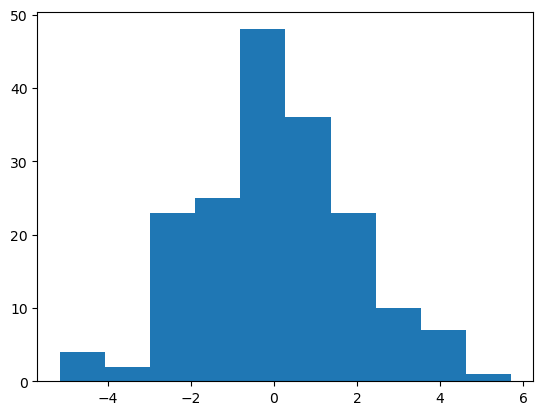

In [17]:
plt.hist(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

(array([ 4.,  2., 23., 25., 48., 36., 23., 10.,  7.,  1.]),
 array([-5.14334938, -4.05878804, -2.97422669, -1.88966535, -0.805104  ,
         0.27945734,  1.36401869,  2.44858004,  3.53314138,  4.61770273,
         5.70226407]),
 <BarContainer object of 10 artists>)

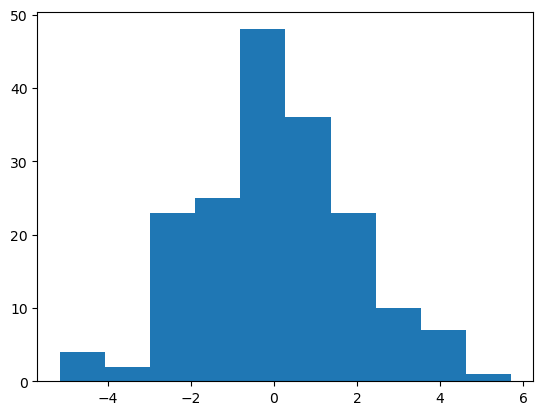

In [18]:
plt.hist(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

In [19]:
np.std(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

np.float64(1.893459707838517)

(array([ 9., 25., 26., 23., 20., 17., 20., 20., 11.,  8.]),
 array([-15.50514258, -12.69195193,  -9.87876128,  -7.06557064,
         -4.25237999,  -1.43918934,   1.3740013 ,   4.18719195,
          7.00038259,   9.81357324,  12.62676389]),
 <BarContainer object of 10 artists>)

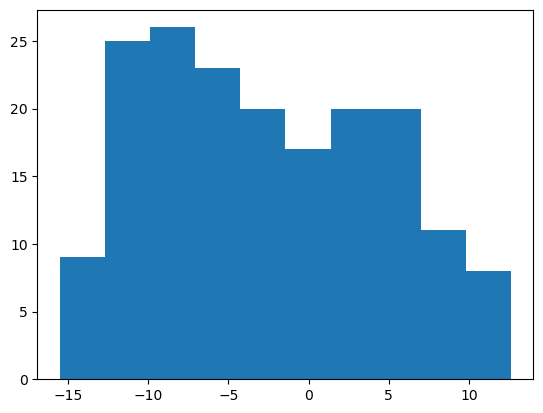

In [20]:
plt.hist(df_h5_filter['h5_mc_core_y'].values-df_mu_good['impact_y_array'].values)

In [21]:
df_mu_good_copy = df_mu_good.copy(deep=True)

In [22]:
std_y_list=[]
std_x_list=[]
i_list=[]
for i in np.arange(0,360, 1):
    df_mu_good_copy['impact_x_bar_array'] = df_mu_good_copy['impact_x_array']*np.cos(i/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.sin(i/180.0*np.pi)
    df_mu_good_copy['impact_y_bar_array'] = -df_mu_good_copy['impact_x_array']*np.sin(i/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.cos(i/180.0*np.pi)
    std_y=np.std(df_h5_filter['h5_mc_core_y'].values-df_mu_good_copy['impact_y_bar_array'].values)
    std_x=np.std(df_h5_filter['h5_mc_core_x'].values-df_mu_good_copy['impact_x_bar_array'].values)
    std_y_list.append(std_y)
    std_x_list.append(std_x)
    i_list.append(i)
    #print(i," ",std_y," ",std_x)

std_y_list=np.array(std_y_list)
std_x_list=np.array(std_x_list)
i_list=np.array(i_list)

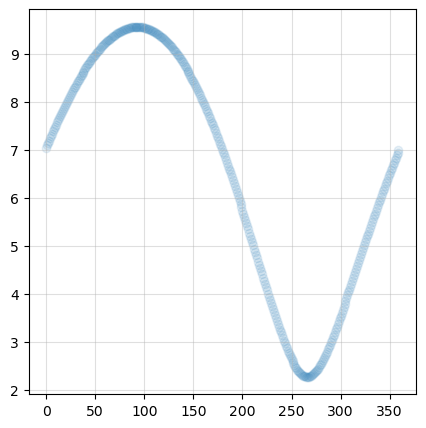

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(i_list,std_x_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

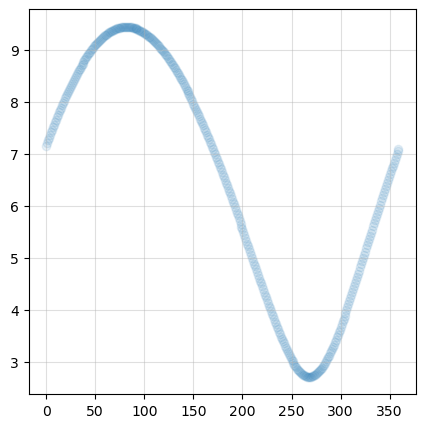

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(i_list,std_y_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

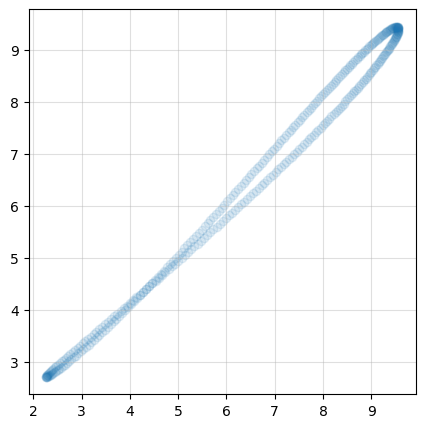

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(std_x_list,std_y_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [26]:
print(np.argmin(std_y_list))
print(np.argmin(std_y_list))
print(360.0-i_list[268])

268
268
92.0


In [27]:
df_mu_good_copy['impact_x_bar_array'] = df_mu_good_copy['impact_x_array']*np.cos(268/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.sin(268/180.0*np.pi)
df_mu_good_copy['impact_y_bar_array'] = -df_mu_good_copy['impact_x_array']*np.sin(268/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.cos(268/180.0*np.pi)   

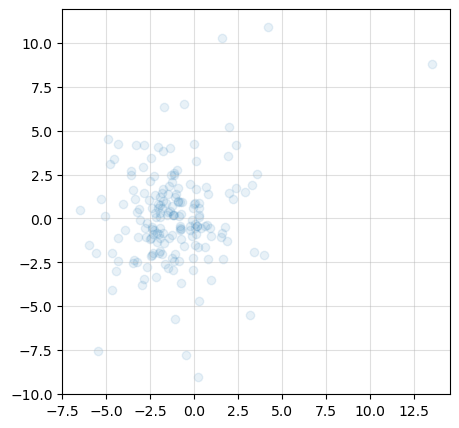

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter((df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values),(df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values),alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

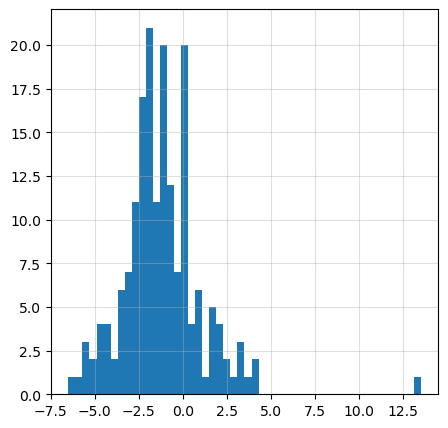

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist((df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values),bins=50,alpha=1)
ax.grid(True,alpha=0.4)
plt.show()

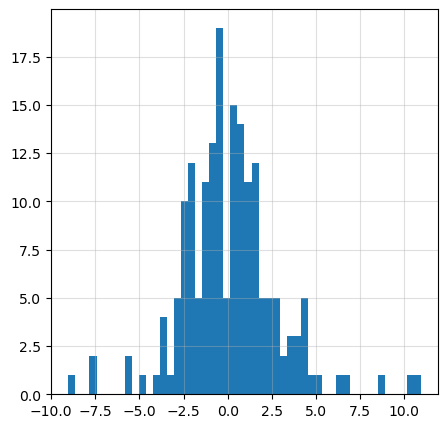

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist((df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values),bins=50,alpha=1)
ax.grid(True,alpha=0.4)
plt.show()

In [31]:
np.std(df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values)

np.float64(2.7122776210255632)

In [32]:
np.std(df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values)

np.float64(2.273283121078508)

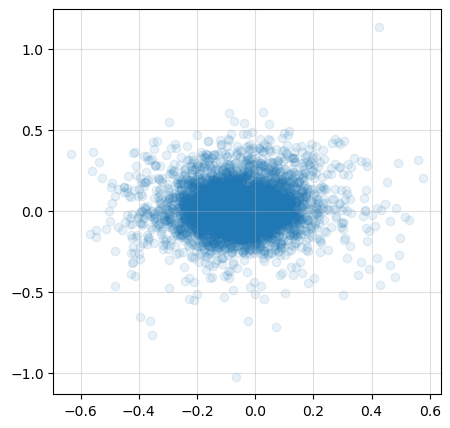

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['ring_center_x'],df_mu['ring_center_y'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

#ax.legend()
    #ax.set_xlim(0,200)
#ax.set_yscale("log")
#a

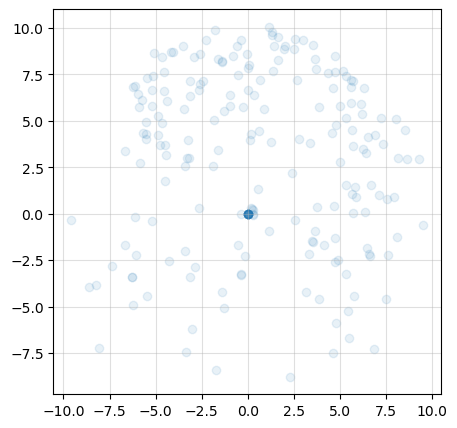

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['impact_x_array'],df_mu['impact_y_array'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

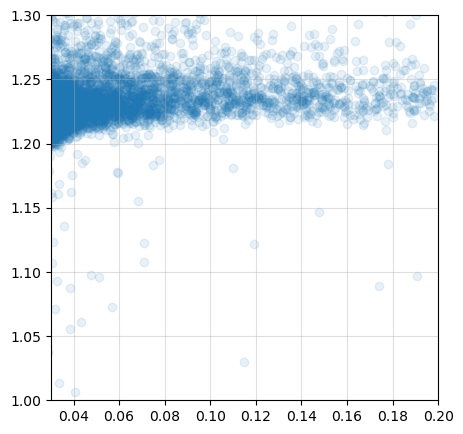

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['mc_energy'],df_mu['ring_radius'],alpha=0.1)
ax.set_xlim(0.03,0.2)
ax.set_ylim(1.0,1.3)
ax.grid(True,alpha=0.4)
plt.show()

In [36]:
df_mu_all_good=df_mu[df_mu['good_ring']==True]

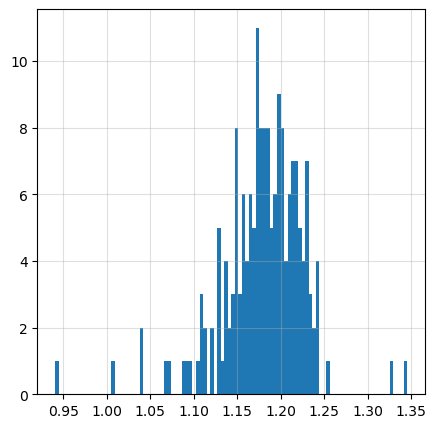

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(df_mu_all_good['ring_radius'].values,bins=100,alpha=1)
#ax.set_xlim(0.03,0.2)
#ax.set_ylim(1.0,1.3)
ax.grid(True,alpha=0.4)
plt.show()

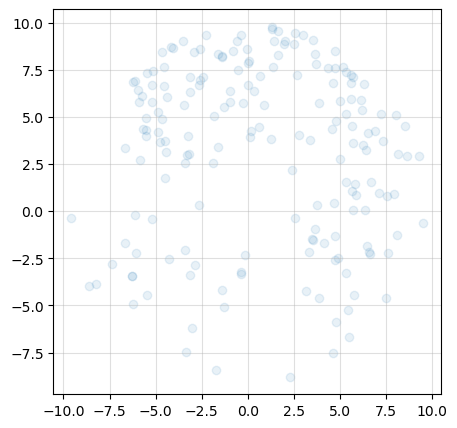

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu_all_good['impact_x_array'],df_mu_all_good['impact_y_array'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

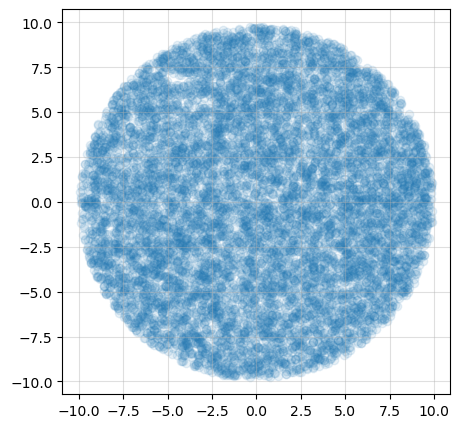

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_h5['h5_mc_core_x'],df_h5['h5_mc_core_y'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

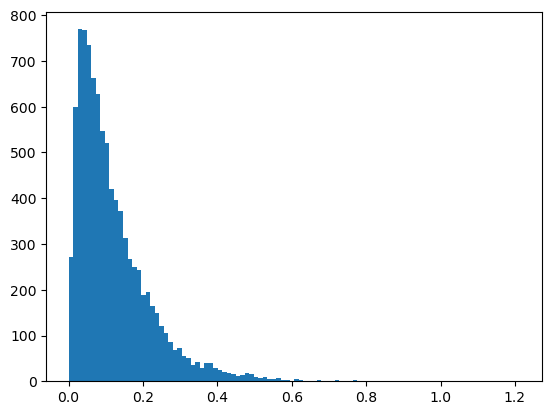

In [40]:
bins=plt.hist(df_mu['ring_center_r'].values, bins=100)

In [41]:
the_h5_table

/dl1/event/telescope/parameters/LST_LSTCam (Table(np.int64(9984),)fletcher32, shuffle, blosc:zstd(1)) np.str_('')
  description := {
  "obs_id": Int32Col(shape=(), dflt=np.int32(0), pos=0),
  "event_id": Int64Col(shape=(), dflt=np.int64(0), pos=1),
  "intensity": Float64Col(shape=(), dflt=np.float64(0.0), pos=2),
  "log_intensity": Float64Col(shape=(), dflt=np.float64(0.0), pos=3),
  "x": Float64Col(shape=(), dflt=np.float64(0.0), pos=4),
  "y": Float64Col(shape=(), dflt=np.float64(0.0), pos=5),
  "r": Float64Col(shape=(), dflt=np.float64(0.0), pos=6),
  "phi": Float64Col(shape=(), dflt=np.float64(0.0), pos=7),
  "length": Float64Col(shape=(), dflt=np.float64(0.0), pos=8),
  "length_uncertainty": Float64Col(shape=(), dflt=np.float64(0.0), pos=9),
  "width": Float64Col(shape=(), dflt=np.float64(0.0), pos=10),
  "width_uncertainty": Float64Col(shape=(), dflt=np.float64(0.0), pos=11),
  "psi": Float64Col(shape=(), dflt=np.float64(0.0), pos=12),
  "skewness": Float64Col(shape=(), dflt=np.f

In [42]:
np.mean(df_mu['mc_energy'].values)

np.float64(0.04073050329924444)

<Axes: >

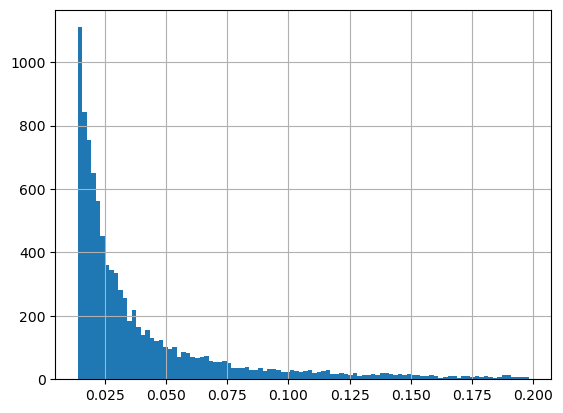

In [43]:
df_mu['mc_energy'].hist(bins=100)

In [44]:
np.mean(df_mu['ring_center_x'].values)

np.float64(-0.042660467018568494)

In [45]:
the_h5_table

/dl1/event/telescope/parameters/LST_LSTCam (Table(np.int64(9984),)fletcher32, shuffle, blosc:zstd(1)) np.str_('')
  description := {
  "obs_id": Int32Col(shape=(), dflt=np.int32(0), pos=0),
  "event_id": Int64Col(shape=(), dflt=np.int64(0), pos=1),
  "intensity": Float64Col(shape=(), dflt=np.float64(0.0), pos=2),
  "log_intensity": Float64Col(shape=(), dflt=np.float64(0.0), pos=3),
  "x": Float64Col(shape=(), dflt=np.float64(0.0), pos=4),
  "y": Float64Col(shape=(), dflt=np.float64(0.0), pos=5),
  "r": Float64Col(shape=(), dflt=np.float64(0.0), pos=6),
  "phi": Float64Col(shape=(), dflt=np.float64(0.0), pos=7),
  "length": Float64Col(shape=(), dflt=np.float64(0.0), pos=8),
  "length_uncertainty": Float64Col(shape=(), dflt=np.float64(0.0), pos=9),
  "width": Float64Col(shape=(), dflt=np.float64(0.0), pos=10),
  "width_uncertainty": Float64Col(shape=(), dflt=np.float64(0.0), pos=11),
  "psi": Float64Col(shape=(), dflt=np.float64(0.0), pos=12),
  "skewness": Float64Col(shape=(), dflt=np.f

In [46]:
h5_out_obs_id=the_h5_table[:]['obs_id']
h5_out_event_id=the_h5_table[:]['event_id']
h5_out_mc_energy=the_h5_table[:]['mc_energy']
h5_out_mc_core_x=the_h5_table[:]['mc_core_x']
h5_out_mc_core_y=the_h5_table[:]['mc_core_y']
h5_out_mc_alt=the_h5_table[:]['mc_alt']
h5_out_mc_az=the_h5_table[:]['mc_az']

In [47]:
the_h5_table_image=h5file.root.dl1.event.telescope.image.LST_LSTCam

In [48]:
image_charge_arr=the_h5_table_image[:]['image']

In [49]:
image_time_arr=the_h5_table_image[:]['peak_time']

In [50]:
meta_data_arr=np.array([h5_out_obs_id,h5_out_event_id,h5_out_mc_energy,h5_out_mc_core_x,h5_out_mc_core_y,h5_out_mc_alt,h5_out_mc_az]).transpose()
meta_data_arr_columns=['obs_id','event_id','mc_energy','mc_core_x','mc_core_y','mc_alt','mc_az']

In [51]:
[meta_data_arr_columns.append(str('ch'+str(i))) for i in np.arange(len(the_h5_table_image[0]['image']))];

In [52]:
[meta_data_arr_columns.append(str('cht'+str(i))) for i in np.arange(len(the_h5_table_image[0]['image']))];

In [53]:
#for i in np.arange(len(the_h5_table_image[0]['image'])):
#    col_name=str('ch'+str(i))
#    meta_data_arr_columns.append(col_name)

In [54]:
df_h5_out = pd.DataFrame(np.column_stack((meta_data_arr,image_charge_arr,image_time_arr)), columns=meta_data_arr_columns)

In [55]:
print(the_h5_table_image[:]['image'].shape)
print(meta_data_arr.shape)

(9984, 1855)
(9984, 7)


In [56]:
df_h5_out

,obs_id,event_id,mc_energy,mc_core_x,mc_core_y,mc_alt,mc_az,ch0,ch1,ch2,...,cht1845,cht1846,cht1847,cht1848,cht1849,cht1850,cht1851,cht1852,cht1853,cht1854
0,100.0,100.0,0.043764,5.265851,5.839925,1.396200,3.141083,1.728506,1.019590,1.884974,...,2.146833,5.259359,37.783646,37.652397,22.278975,1.979133,14.767467,8.926561,33.673206,34.548149
1,100.0,200.0,0.188201,5.852325,-5.821779,1.396314,3.141849,0.259989,0.282336,0.172243,...,34.270992,8.168234,21.660305,30.292444,34.355412,3.210904,4.177964,20.423679,23.200659,22.422804
2,100.0,300.0,0.023677,0.021167,5.211458,1.396264,3.141077,3.476025,1.667865,4.878283,...,21.142687,20.338453,37.641083,0.952235,14.313764,11.755533,21.721718,2.259111,17.578840,6.881151
3,100.0,400.0,0.017206,-7.965814,-5.719480,1.396132,3.141508,2.822277,0.473005,2.874394,...,32.002617,26.773031,13.797265,35.095100,24.856512,1.782466,37.636299,0.211813,35.305862,35.104240
4,100.0,500.0,0.020826,-0.077619,6.992402,1.396145,3.141931,1.803939,1.667865,2.147985,...,16.471476,3.049575,0.975088,21.662106,35.527870,0.621106,18.096462,36.923321,35.375759,22.141132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,100.0,999600.0,0.019139,-3.306893,-3.857464,1.396325,3.141129,3.186867,-0.099003,0.770312,...,20.057285,19.632822,19.588673,21.701300,7.190060,6.698928,5.905467,10.169498,6.622454,36.019844
9980,100.0,999700.0,0.022005,-6.014100,2.147953,1.396332,3.142337,1.175335,1.744133,2.761676,...,22.782633,0.281772,13.642262,2.777678,17.051987,13.460336,30.080507,9.437328,3.767727,0.042009
9981,100.0,999800.0,0.031409,-2.607592,-4.764127,1.396196,3.140775,3.451685,2.519521,0.106524,...,20.985319,10.735547,0.510835,11.824518,9.033742,16.826445,36.716774,25.371824,36.267891,8.846031
9982,100.0,999900.0,0.042862,0.117316,2.983726,1.396186,3.141992,1.389060,1.971928,2.749926,...,12.222626,19.856188,3.195211,12.235274,5.031684,34.040573,26.985405,21.517710,15.217849,10.533301


In [ ]:
df_h5_out.to_csv('test.csv',sep=" ")

In [ ]:
np.shape(the_h5_table_image[:]['image'])

In [ ]:
plt.hist(the_h5_table_image[0]['image'],bins=100)

In [ ]:
the_h5_table_image[0]['image']

In [ ]:
df_h5_out.shape